# Analysis of Wikipedia Network
Elliot Williams<br>March 24, 2018<br>Web Scraping w. Prof. Oleinikov

## Background

Before this point, I ran `extractHTML.sh` on the entire set of Wikipedia articles, accessible from the [Internet Archive](https://archive.org/search.php?query=subject%3A%22enwiki%22%20AND%20subject%3A%22data%20dumps%22%20AND%20collection%3A%22wikimediadownloads%22&and[]=subject%3A%22Wikipedia%22), resulting in 54 files representing the adjacency list of the directed Wikipedia network (in which articles are nodes, hyperlinks edges).

## Analyzing the Results

Now, I want to plot the out degree distribution of the Wikipedia network, as well as see some instances of high-degree nodes.

Let's start by figuring out the number of nodes and edges in all the files...

(**Sidenote**: I'm running this on the CS kurtz server -- it takes forever to run on my laptop -- and I'm using [ray](http://ray.readthedocs.io/en/latest/) to run some of my code -- ie `getOutdegs` -- in parallel without having to implement it in parallel myself)

In [1]:
import re
import glob
import ray

# Gets list of all adjacency list files
file_list = glob.glob("./link_files/*.dat")

'''
The following function reads in a given adjacency list file and returns
'''
@ray.remote
def getOutdegs(filename):
    f = open(filename)

    # Parses out HTTP links --> just in case any got through the initial search
    # Also, some of the links contain '#' pointers to specific parts of an article 
    # -- let's remove these (both done in one loop for speed purposes)
    lines = [re.sub("#.*", "", line.strip()) for line in f if 
             not re.search("https?:\/\/", line)]

    t_indices = [i for i in range(len(lines)) if re.search(">>>>", lines[i])]

    print("There are {} nodes represented in this file".format(len(t_indices)))
    print("There are {} edges in this file".format(len(lines) - len(t_indices)))
    
    titles   = [re.sub(">>>>", "", lines[i]) for i in t_indices]
    out_degs = [t_indices[i+1] - t_indices[i] - 1 
                for i in range(len(t_indices) - 1)]
    t_outdegs = list(zip(titles, out_degs))
    t_outdegs.sort(key=lambda x : x[1], reverse=True)
    return(t_outdegs)

ray.init()
file_results = ray.get([getOutdegs.remote(filename) for filename in file_list])

Waiting for redis server at 127.0.0.1:48867 to respond...
Waiting for redis server at 127.0.0.1:16748 to respond...
Starting local scheduler with the following resources: {'CPU': 16, 'GPU': 0}.

View the web UI at http://localhost:8888/notebooks/ray_ui26364.ipynb?token=c8c0f553d469745ce111b513ed48ea6e004f91d000c62f0f



In [2]:
from functools import reduce
t_outdegs = reduce(lambda x,y : x + y, file_results)
t_outdegs.sort(key=lambda x: x[1], reverse=True)

In [15]:
t_outdegs[1:50]
len(t_outdegs)

import pandas as pd
titles, outdegs = zip(*t_outdegs)

In [18]:
df = pd.DataFrame({"title": titles, "outdeg":outdegs})
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [39]:
%%R -i df -o counts
library(dplyr)

counts <- df %>%
group_by(outdeg) %>%
summarize(n=n()) %>%
arrange(desc(n))

In [ ]:
%%R -i df counts



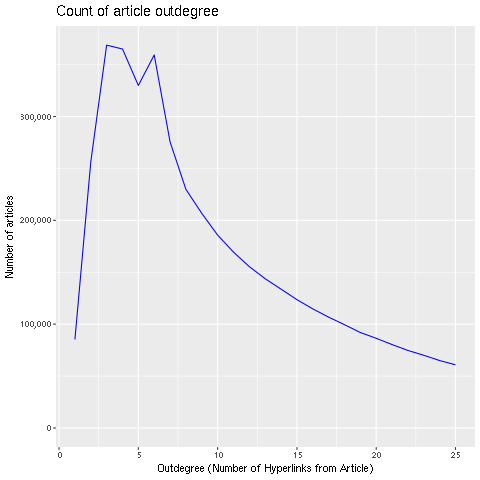

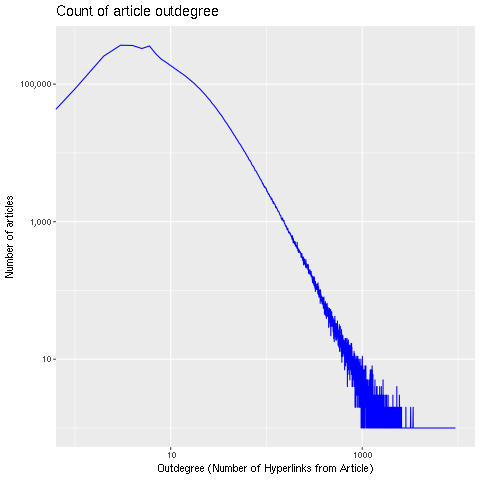

In [36]:
%%R -i counts
library(ggplot2)

print(ggplot(counts, aes(x=outdeg, y=n)) + geom_line(color="blue") +
labs(x="Outdegree (Number of Hyperlinks from Article)",
     y="Number of articles",
     title="Count of article outdegree") + xlim(1,25) +
scale_y_continuous(labels = scales::comma))



ggplot(counts, aes(x=outdeg, y=n)) + geom_line(color="blue") +
labs(x="Outdegree (Number of Hyperlinks from Article)",
     y="Number of articles",
     title="Count of article outdegree") + 
scale_y_continuous(labels = scales::comma, trans="log10") +
scale_x_continuous(trans="log10")